# Data Analysis

In this notebook we discuss basic issues in analysing the extracted AFL data, and provide
some initial exploratory data analyses.

## Training and testing data

As previously discussed in
[Chapter 1](1_introduction.ipynb#Model-validation "Introduction: Model validation"),
for the purposes of data analysis and modelling we should partition the data into *training* and 
*testing* sets. Only the training data should be subject to exploratory data analysis, and the testing data should be kept only for model validation. Actually, to be completely fair, there should also be an additional *validation* data-set. Multiple models should be validated against this data-set, and only the selected, best model should be tested on the testing data.

However, in a 'live' system, the *retrospective* analysis of model building would be coupled with *prospective* prediction of future matches, so these yet-to-be-collected matches would act as ongoing testing data. Monitoring of predictive performance and data distributions over time would then also
allow testing for other issues such as 
[*concept drift*](https://en.wikipedia.org/wiki/Concept_drift "Wikipedia"),
where the model no longer accurately reflects the data.

Recall from [Chapter 3](3_feature_extraction.ipynb "Chapter 3: Feature Extraction")
that historical features were extracted for every collected AFL match. Consequently, we are permitted to treat each match, coupled with its corresponding features, as being 
[independent](1_introduction.ipynb#Causality-and-independence-of-observations
"Introduction: Causality and independence of observations").
For simplicity, we arbitrarily take all matches from 1990 to 2020 as the training data, and matches from 2021 onwards as testing/validation data. 

A better scheme might have been to randomly partition the matches per season, or even completely at random per match. However, this would make it harder to test for temporal representativeness (a form of concept drift discussed in a
[later](#Temporal-representativeness "Section: Temporal representativeness") section).
In addition, we would typically apply a partitioning rule such as 90/10 or 80/20, to control
the proportion of training data to testing data. 

### Load the data

In [1]:
import sys
import os

sys.path.append(os.path.join("..", "python"))

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
df_matches = pd.read_csv(os.path.join("..", "data", "matches.csv"))

In [5]:
df_matches

,season,round,datetime,venue,for_team,for_is_home,for_goals1,for_behinds1,for_goals2,for_behinds2,...,against_goals3,against_behinds3,against_goals4,against_behinds4,against_total_score,against_match_points,against_is_win,against_is_draw,against_is_loss,edge_type
0,1990,R1,Sat 31-Mar-1990 2:10 PM,Princes Park,Carlton,True,6,5,4,4,...,6,3,6,5,104,4,True,False,False,lost-to
1,1990,R1,Sat 31-Mar-1990 2:10 PM,M.C.G.,Melbourne,False,6,2,4,1,...,4,4,3,4,89,0,False,False,True,defeated
2,1990,R1,Sat 31-Mar-1990 2:10 PM,Waverley Park,Geelong,True,5,3,2,3,...,9,7,10,6,192,4,True,False,False,lost-to
3,1990,R1,Sat 31-Mar-1990 2:10 PM,Windy Hill,Essendon,True,7,4,6,7,...,1,3,2,4,60,0,False,False,True,defeated
4,1990,R1,Sat 31-Mar-1990 7:40 PM,Carrara,Brisbane Bears,True,4,3,3,2,...,1,3,3,2,74,0,False,False,True,defeated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6489,2024,R7,Sat 20-Apr-2024 4:35 PM,Docklands,Carlton,True,5,1,2,6,...,3,3,3,1,98,0,False,False,True,defeated
6490,2024,R7,Sat 20-Apr-2024 6:10 PM,Perth Stadium,Fremantle,False,0,3,3,0,...,5,5,2,0,105,4,True,False,False,lost-to
6491,2024,R7,Sat 20-Apr-2024 7:30 PM,Gabba,Brisbane Lions,True,2,5,1,3,...,2,2,3,3,63,4,True,False,False,lost-to
6492,2024,R7,Sun 21-Apr-2024 1:05 PM,S.C.G.,Gold Coast,False,1,2,2,3,...,7,4,5,0,110,4,True,False,False,lost-to


In [6]:
print(df_matches.columns)

Index(['season', 'round', 'datetime', 'venue', 'for_team', 'for_is_home',
       'for_goals1', 'for_behinds1', 'for_goals2', 'for_behinds2',
       'for_goals3', 'for_behinds3', 'for_goals4', 'for_behinds4',
       'for_total_score', 'for_match_points', 'for_is_win', 'for_is_draw',
       'for_is_loss', 'against_team', 'against_is_home', 'against_goals1',
       'against_behinds1', 'against_goals2', 'against_behinds2',
       'against_goals3', 'against_behinds3', 'against_goals4',
       'against_behinds4', 'against_total_score', 'against_match_points',
       'against_is_win', 'against_is_draw', 'against_is_loss', 'edge_type'],
      dtype='object')


### Partition the data

In [7]:
all_seasons = df_matches.season.unique()

In [8]:
split_season = 2020
trn_seasons = all_seasons[all_seasons <= split_season]
tst_seasons = all_seasons[all_seasons > split_season]

In [9]:
df_training = df_matches[df_matches.season.isin(trn_seasons)].copy()

In [10]:
df_training.iloc[[0, -1]]

,season,round,datetime,venue,for_team,for_is_home,for_goals1,for_behinds1,for_goals2,for_behinds2,...,against_goals3,against_behinds3,against_goals4,against_behinds4,against_total_score,against_match_points,against_is_win,against_is_draw,against_is_loss,edge_type
0,1990,R1,Sat 31-Mar-1990 2:10 PM,Princes Park,Carlton,True,6,5,4,4,...,6,3,6,5,104,4,True,False,False,lost-to
5809,2020,GF,Sat 24-Oct-2020 6:30 PM,Gabba,Geelong,False,2,2,3,3,...,4,2,5,5,81,4,True,False,False,lost-to


In [11]:
df_testing = df_matches[df_matches.season.isin(tst_seasons)].copy()

In [12]:
df_testing.iloc[[0, -1]]

,season,round,datetime,venue,for_team,for_is_home,for_goals1,for_behinds1,for_goals2,for_behinds2,...,against_goals3,against_behinds3,against_goals4,against_behinds4,against_total_score,against_match_points,against_is_win,against_is_draw,against_is_loss,edge_type
5810,2021,R1,Thu 18-Mar-2021 7:25 PM,M.C.G.,Carlton,False,3,2,3,4,...,2,3,5,7,105,4,True,False,False,lost-to
6493,2024,R7,Sun 21-Apr-2024 4:05 PM,Docklands,Hawthorn,False,3,3,8,3,...,3,1,2,2,68,0,False,False,True,defeated


In [13]:
print("%d training samples" % len(df_training))
print("%d testing samples" % len(df_testing))
p = len(df_training) / len(df_matches)
print("Ratio:", 100 * p, ":", 100 * (1 - p))

5810 training samples
684 testing samples
Ratio: 89.46720049276256 : 10.532799507237446


### Save the partitioned data

In [14]:
 df_training.to_csv(os.path.join("..", "data", "training_matches.csv"), index=False)

In [15]:
df_testing.to_csv(os.path.join("..", "data", "testing_matches.csv"), index=False)

Note that, strict speaking, we should also partition the extracted features in the same fashion, in order to
obviate the possibility of contaminating our data anlyses with testing data.
In practice, we shall permit the loading of all historical data, on the assumption that queries will
only be made for matches in the training data-set.

## Null hypothesis

A typical assumption of probabilistic modelling is that every data point is independently drawn from the same underlying distribution. This is just a form of the *null* hypothesis, corresponding to the *business as usual* (BAU) rule that nothing much changes.
Informally, this means that each team is much like every other team, each match is like other matches, and each season is like other seasons.
More formally, we notionally assume the existence of a single, joint distribution from which all teams and matches are sampled.

In reality, the null hypothesis cannot strictly hold true always and everywhere. If it did, then the characteristics of each team would be stochastically sampled before a match, the results of each match would also be sampled, and consequently there would be little value in collecting historical data.
However, in practice it is apparent that some teams are stronger than others, and that this relative strength has some temporal persistence (even if only for one or more seasons). 

The benefit of considering the null hypothesis lies in aggregration. Considered over a period of time (say, a season), some teams are weak, some are strong, and some are inbetween. Thus, the teams might be thought of as being sampled from some common distribution, and it makes sense to consider the characteristics of an 'average' team. Put another way, if we consider past matches between team A and all other opponents, then team A will have faced both stronger teams and weaker teams in aggregate.
The null hypothesis is then to assume that  all such team differences cancel out on average. Consequently, we may model the outcomes of these matches as measuring the relative performance of team A against the hypothetical 'average' team. This is just the so-called *one-team* model
discussed in [Chapter 1](1_introduction.ipynb#Marginal-models "Introduction: Marginal models").

For the purposes of modelling, it is of interest to know when the null hypothesis fails. For example, if any one team is no longer just like another, then it is useful to capture these differences so
that we may more precisely predict the outcome of a match between team A and team B using
a [*two-team*](1_introduction.ipynb#Marginal-models "Introduction: Marginal models")
model.

If the null hypothesis does not hold across time, then we call this a failure of
[*temporal representativeness*](#Temporal-representativeness "Section: Temporal representativeness").
However, note that the null hypothesis might hold on one time-scale but fail to hold on a different time-scale. 
For example, if the null hypothesis were to happen to fail across multiple seasons, 
then perhaps it might still hold within a season. For instance, the relative strengths of teams might have (notionally) been sampled at the start of a season, and then held fixed for the duration of that season.

Similarly, if the null hypothesis does not hold due to environmental factors or physical constraints, then we call this a failure of 
[*physical representativeness*](#Physical-representativeness "Section: Physical representativeness").
For example, teams from different cities or suburbs might potentially show a disparity in performance due to differences in socio-economic status (e.g. due to the availability, or lack thereof, of sufficient funds to  contract top players). Likewise, we might expect most teams to play better
in dry conditions than rainy conditions, but some teams might be less affected by slippery conditions than others.

## Emprical distributions

In the following sections, we assume a priori that the 
[null hypothesis](#Null-hypothesis "Section: Null hypothesis") holds true.
Under this assumption, we aggregate all matches and examine the empirical distributions
derived from match outcomes.

### Likelihood of a draw

At the end of an Australian Rules football match, the scores of the two opposing teams might be tied, resulting in a draw. However, as discussed in [Chapter 1](1_introduction.ipynb#The-effect-of-draws
"Introduction: The effect of draws"), draws by their nature must be statisticaly unlikely events.
Consequently, it makes sense to aggregate all matches to help overcome the scarcity of draws.

In [16]:
df_training.edge_type.unique()

array(['lost-to', 'defeated', 'drew-with'], dtype=object)

In [17]:
df_training['is_draw'] = is_draw = df_training.edge_type == 'drew-with'
p_draw = np.mean(is_draw)
num_matches = len(df_training)
#std_err = np.sqrt(np.var(is_draw) / num_matches)
std_err = np.sqrt(p_draw * (1 - p_draw) / num_matches)
print(f"Draws: matches={num_matches}, draws={sum(is_draw)}, mean={p_draw}, std. err.={std_err}")

Draws: matches=5810, draws=50, mean=0.008605851979345954, std. err.=0.0012118030613057298


We observe that the empirical probability of a draw is around 1% or less.

### Distribution of goals

The number of goals scored by a given team in a given match is a non-negative integer.
Consequently, one could potentially assume a priori that the number of goals (in a given period of time) might follow a Poisson distribution, assuming that the rate of goal scoring remains
constant. To partially allow for the goal rate to vary in each quarter of a match (e.g. due perhaps to accumulating fatigue), we aggregate the scores over all four quarters.

We also assume for convenience that every match takes the same amount of time to complete,
with the current length of each quarter being nominally about 20 minutes.
However, this is not actually true in practice, primarily due to variations in timing due
to stoppages, e.g. when the ball goes out of play, or when there are player injuries.
Additionally, it must be noted that prior to 1994, the alotted time was actually 25 minutes per quarter. Also, due to the outbreak of Covid in 2020, the time was reduced for that season to only 16 minutes per quarter. We make simple adjustments for these variations in this analysis.

In [18]:
columns  = ['for_goals' + str(i) for i in range(1, 5)]
for_goals = np.sum(df_training[columns].values, axis=1, dtype=float)
columns  = ['against_goals' + str(i) for i in range(1, 5)]
against_goals = np.sum(df_training[columns].values, axis=1, dtype=float)

In [19]:
# Reduce time per quarter from 25 to 20
ind = df_training.season < 1994
for_goals[ind] *= 20 / 25
against_goals[ind] *= 20 / 25
# Increase time per quarter from 16 to 20
ind = df_training.season == 2020
for_goals[ind] *= 20 / 16
against_goals[ind] *= 20 / 16

In [20]:
all_goals = np.concatenate([[for_goals, against_goals]], axis=None)
goal_mean = np.mean(all_goals)
goal_var = np.var(all_goals)
print(f"Goals: mean={goal_mean}, variance={goal_var}")

Goals: mean=13.13802065404475, variance=20.381749782705942


The over-dispersion of the variance (which should otherwise appproximately equal the mean)
rules out a simple Poisson distribution. One possibility is that goal scoring is still Poisson but with a variable rate. For example, if the scoring rate was resampled for each match from a Gamma
distribution, then the overall number of goals would follow a negative binomial distribution.

In [21]:
from scipy import stats as sci_stats

In [22]:
alpha, loc, beta = sci_stats.gamma.fit(all_goals)
x_values = np.linspace(min(all_goals), max(all_goals), 100)
y_values = sci_stats.gamma.pdf(x_values, alpha, loc=loc, scale=beta)

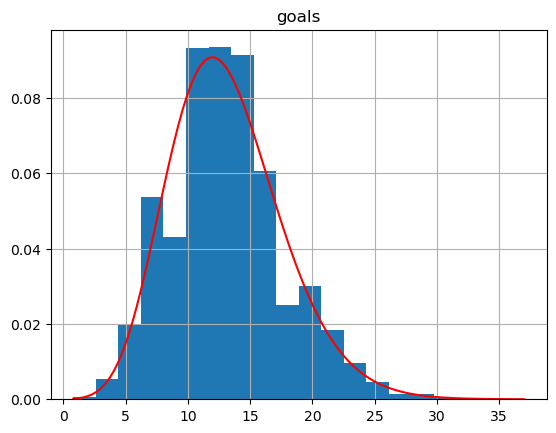

In [23]:
df_goals = pd.DataFrame({'goals': all_goals})
res = df_goals.hist(bins=20, density=True)
ax = res[0][0]
res = ax.plot(x_values, y_values, 'r')

In [24]:
sci_stats.nbinom.fit(all_goals)

AttributeError: 'nbinom_gen' object has no attribute 'fit'

In [25]:
from gamma_dist import GammaDistribution

In [26]:
gd = GammaDistribution()
gd.fit(all_goals)

(-2.909294655346973, 131, 9.801057481162445e-07)

In [28]:
y_values = np.exp(gd.log_prob(x_values))

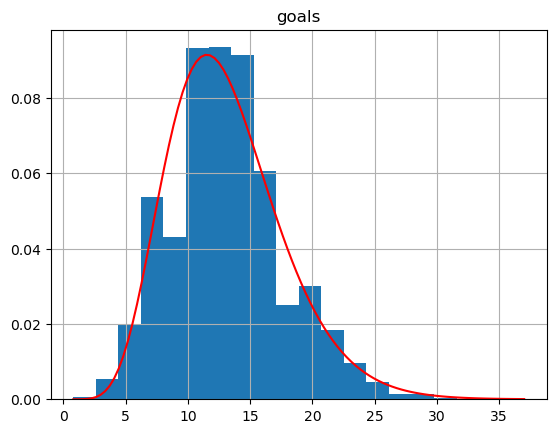

In [29]:
df_goals = pd.DataFrame({'goals': all_goals})
res = df_goals.hist(bins=20, density=True)
ax = res[0][0]
res = ax.plot(x_values, y_values, 'r')

## Physical representativeness

A basic assumption of probabilistic modelling is that every data point (i.e. every match) is drawn from the *same* underlying distribution. This is just the null hypothesis discussed in a
[previous](#Null-hypothesis "Section: Null hypothesis") section.
However, the outcome of each AFL match depends upon both the laws of physics and the rules of the
game. For example, there is a minimum time it takes to score from any given point of the match ground, which depends upon both player biodynamics and the dimensions of the oval (i.e. physics).
This in turn determines the maximum possible score in a fixed period of time.

However, the (nominal) length of a *quarter* depends upon the rules, which change over time.
Thus, the maximum possible score per match can also change.
Furthermore, various aspects of the game, e.g. the ability to tackle other players, also vary according to the rules. For example, the rate of scoring will be reduced when the free flow of the game is interrupted by umpires awarding penalties.

These factors raise some difficult issues. Is a given match representative of the (assumed) underlying distribution? Is one season really much like another? We shall examine some of these issues in the sections below.

### Match venue effects

Due to historical reasons, not all match grounds have the same physical dimensions.
As discussed above, this is one physical factor that determines the team scores in a match.
It might be reasoned that such physical constraints affect each team equally, and hence do not
mattter when predicting which team will win. Conversely, it might be argued that a smaller oval will give each team's defence less opportunity to restrict scoring shots by the opposition offense, and this might favour a distinctly stronger team, e.g. a team that can run faster or kick the ball further.

In order to test this effect, we examine the distribution of scores for each match venue and
see whether or not these distributions differ markedly.
Note that although the local name of each sporting ground might change over time due to naming rights from sponsorship deals, the extracted names of the venues have already been normalised.

In [ ]:
all_venues = sorted(df_training.venue.unique())
print("Found %d distinct venues" % len(all_venues))

For convenience, we ignore matches from infrequently used venues.

In [ ]:
min_num_matches = 10

In [ ]:
ds = df_training.sort_values("venue").groupby("venue").apply(len)
ind = ds >= min_num_matches  # Reject infrequent
df_sample = df_training[df_training.venue.isin(ds.index[ind])]

In [ ]:
def score_stats(df):
    scores = df[['for_total_score', 'against_total_score']].values
    n = np.size(scores)
    m = np.mean(scores)
    v = np.var(scores)
    se = np.sqrt(v / n)
    data = n, m, v, se
    index = 'size', 'mean', 'var', 'std_err'
    return pd.Series(data, index)

In [ ]:
ds_stats = score_stats(df_sample)
print(ds_stats)

In [ ]:
def group_score_stats(df, group_name):
    df_out = df.groupby(group_name).apply(score_stats)
    df_out.reset_index(drop=False, inplace=True)
    return df_out

In [ ]:
df_stats = group_score_stats(df_sample, "venue")
df_stats['sig'] = (df_stats['mean'] - ds_stats['mean']) / df_stats.std_err
print(df_stats)

Informally, we might plot the mean score of each venue along with standard error bars,
and visually check whether these are similar to the overall mean score.

In [ ]:
score_mean = ds_stats['mean']
num_groups = len(df_stats)
x = np.arange(1, num_groups + 1)
plt.plot(x, [score_mean] * num_groups, 'r')
venue_means = df_stats['mean']
plt.plot(x, venue_means, 'g')
venue_ses = df_stats.std_err
plt.plot(x, venue_means + 2 * venue_ses, 'lightgrey')
plt.plot(x, venue_means - 2 * venue_ses, 'lightgrey')
sig = (venue_means - score_mean) / venue_ses
plt.xlabel('Index of venue')
plt.ylabel('Score')
plt.legend(['overall mean', 'venue mean', '2 std. err.'])
plt.show()

This plot suggests that not all venues are like the 'average' venue.

More formally, we could perform an *analysis of variance* (ANOVA).

In [ ]:
def anova(ds_stats, df_stats):
    num_samples = int(ds_stats['size'])
    sse_total = num_samples * ds_stats['var']
    sse_within = np.dot(df_stats['size'], df_stats['var'])
    sse_between = sse_total - sse_within
    print(f"SSE: total={sse_total}, within={sse_within}, between={sse_between}")
    num_groups = len(df_stats)
    deg_total = num_samples - 1
    var_total = sse_total / deg_total
    deg_within = num_samples - num_groups
    var_within = sse_within / deg_within
    deg_between = num_groups - 1
    var_between = sse_between / deg_between
    print(f"DF: total={deg_total}, within={deg_within}, between={deg_between}")
    print(f"Var: total={var_total}, within={var_within}, between={var_between}")
    print("F-score:", var_between / var_within)

In [ ]:
anova(ds_stats, df_stats)

## Temporal representativeness